# NLP: Salary predictions based on the job description, skills, years of experience, type of exmployment and schedule
* For the text-based features, it's a good idea to preprocess them and convert them into numerical representations. You can combine all the text columns into one, perform text cleaning and preprocessing such as lowercasing, removing stop words, and lemmatizing. Then you can tokenize the preprocessed text and apply TF-IDF to obtain a sparse matrix representation of the text. This representation can then be used as input to your model.

* For the numerical features such as experience and employment, you can use them directly in your model. You can consider normalizing these features if needed.

* As for the model, we can consider using a regression model since your target feature is a numerical value (salary). Some popular regression models include Linear Regression, Random Forest Regression, Support Vector Regression (SVR), and Gradient Boosting Regression. You can try out a few of these models and compare their performance to determine which one works best for your problem.

* In terms of combining different types of features, you can concatenate the numerical and text-based features and use them as input to your model. Some models, such as neural networks, can handle different types of features automatically, while others may require more preprocessing.

In [1]:
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
import numpy as np
import keras
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from keras.models import Model
from sklearn.metrics import r2_score

tqdm.pandas()
from sklearn.model_selection import train_test_split
from collections import Counter
from pymystem3 import Mystem
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from tqdm import tqdm

plt.rcParams["figure.figsize"] = [12, 8]

import warnings

import seaborn as sns
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [269]:
# pip install fasttext

  Using cached fasttext-0.9.2.tar.gz (68 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for fasttext
Failed to build fasttext
  Running setup.py install for fasttext: started
  Running setup.py install for fasttext: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [20 lines of output]
  C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\setuptools\dist.py:788: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
    warnings.warn(
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-39
  creating build\lib.win-amd64-cpython-39\fasttext
  copying python\fasttext_module\fasttext\FastText.py -> build\lib.win-amd64-cpython-39\fasttext
  copying python\fasttext_module\fasttext\__init__.py -> build\lib.win-amd64-cpython-39\fasttext
  creating build\lib.win-amd64-cpython-39\fasttext\util
  copying python\fasttext_module\fasttext\util\util.py -> build\lib.win-amd64-cpython-39\fasttext\util
  copying python\fasttext_module\fasttext\util\__init__.py -> build\li

# Загрузка данных

In [72]:
df = pd.read_csv("C:\\Users\\HOME\\PycharmProjects\\NLP_SalaryPrediction\\vacancies_train.csv")
df.head(8)

,name,experience,schedule,employment,description,key_skills,salary
0,Водитель-экспедитор,От 3 до 6 лет,Полный день,Полная занятость,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...",[],42500.0
1,Кладовщик-комплектовщик/оператор 1С,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Списывание материалов в произво...,"['знание пк', 'работа в 1С', 'Работа в команде...",50000.0
2,"Продавец магазина ""Магнит"" (Кировский р-он, В....",Нет опыта,Сменный график,Полная занятость,"В крупнейшую Федеральную сеть магазинов ""Магни...",[],31500.0
3,Администратор магазина (ТЦ Spar),От 1 года до 3 лет,Полный день,Полная занятость,Крупная федеральная сеть магазинов мужской и ж...,[],36700.0
4,Мойщик посуды (кулинария),Нет опыта,Сменный график,Полная занятость,Обязанности: Уборка производственных площадей...,"['Пользователь ПК', 'Грамотная речь', 'Работа ...",37000.0
5,Менеджер-администратор,От 1 года до 3 лет,Полный день,Полная занятость,Международная сеть Школ скорочтения и развития...,"['Навыки межличностного общения', 'Грамотная р...",50000.0
6,Комплектовщик,Нет опыта,Полный день,Полная занятость,Мы прямой работодатель - компания «Форум-Авто»...,"['1С: Склад', 'Работа с оргтехникой', 'Приемка...",53500.0
7,Медицинская сестра,Нет опыта,Гибкий график,Частичная занятость,Работа на территории работодателя: р-н Кущевск...,"['Медицинская документация', 'Лечебная деятель...",12130.0


In [73]:
df_test = pd.read_csv("C:\\Users\\HOME\\PycharmProjects\\NLP_SalaryPrediction\\vacancies_test.csv", index_col=0)
df_test.head(10)

,name,experience,schedule,employment,description,key_skills
id,,,,,,
0,Главный бухгалтер,Более 6 лет,Полный день,Полная занятость,Обязанности:Осуществление организации бухгалте...,"['1С: Предприятие 8', '1C: Предприятие', 'Рабо..."
1,Ассистент врача-стоматолога,От 1 года до 3 лет,Сменный график,Полная занятость,"Обязанности: Ассистировать врачу стоматологу,...","['Пользователь ПК', 'Работа в команде', 'Умени..."
2,Менеджер по продажам,От 1 года до 3 лет,Полный день,Полная занятость,Если ты: хочешь построить карьеру в банковс...,[]
3,Менеджер,От 1 года до 3 лет,Полный день,Полная занятость,Динамично развивающаяся на протяжении 17 лет...,"['Оценка потребностей клиентов', 'оформление д..."
4,Администратор хостела,Нет опыта,Сменный график,Полная занятость,ВОЗМОЖНА РАБОТА С ПРОЖИВАНИЕМ Обязанности: Пр...,[]
5,Полицейский (г. Москва),Нет опыта,Полный день,Полная занятость,Обязанности:- обеспечение правопорядка при мас...,[]
6,Менеджер по работе с клиентами,От 1 года до 3 лет,Гибкий график,Полная занятость,Обязанности: Консультирование клиентов в студ...,"['Заключение договоров', 'Навыки продаж', 'Кон..."
7,Администратор,Нет опыта,Полный день,Полная занятость,Приглашаем администратора в стоматологическую ...,"['Пользователь ПК', 'Работа с кассой', 'Грамот..."
8,Кредитный специалист,Нет опыта,Полный день,Полная занятость,Обязанности: - консультирование клиентов по фи...,"['Грамотная речь', '1С: Предприятие 8', 'Консу..."


# Простейший EDA

Для начала посмотрим на распределение таргета в трейне. Видим выбросы совсем низкой зарплаты. **Посмотрите на описание вакансий с выбросами** -- это может помочь объяснить их объяснить

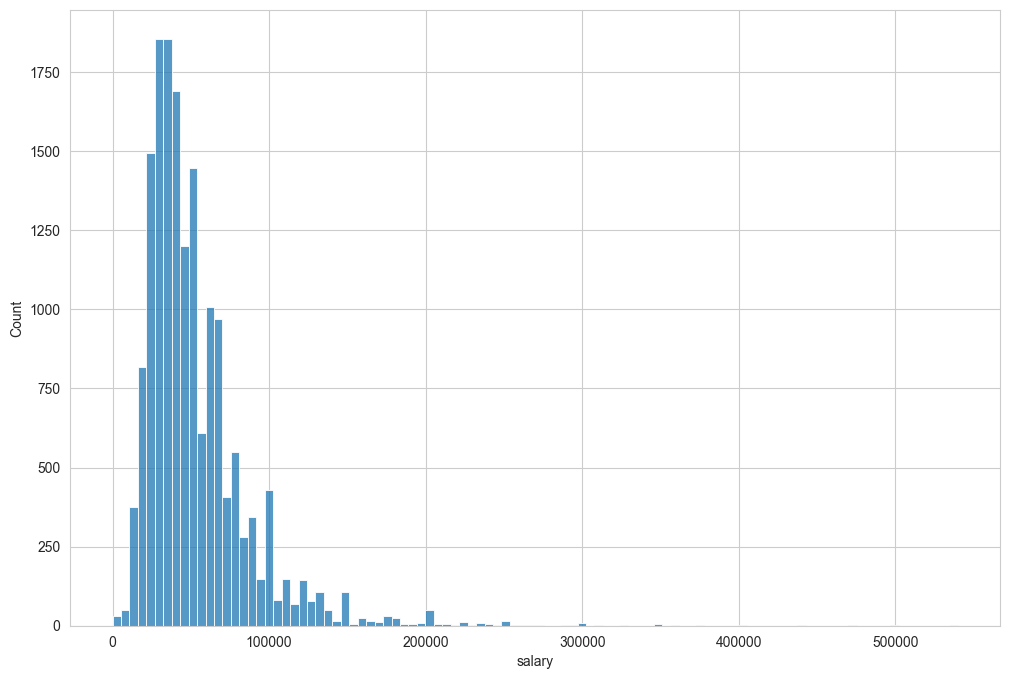

In [74]:
sns.histplot(df.salary, bins=100);

В логарифмированной шкале распределение больше похоже на нормальное. **Подумайте, возможно стоит как-нибудь обработать выбросы или их удалить**

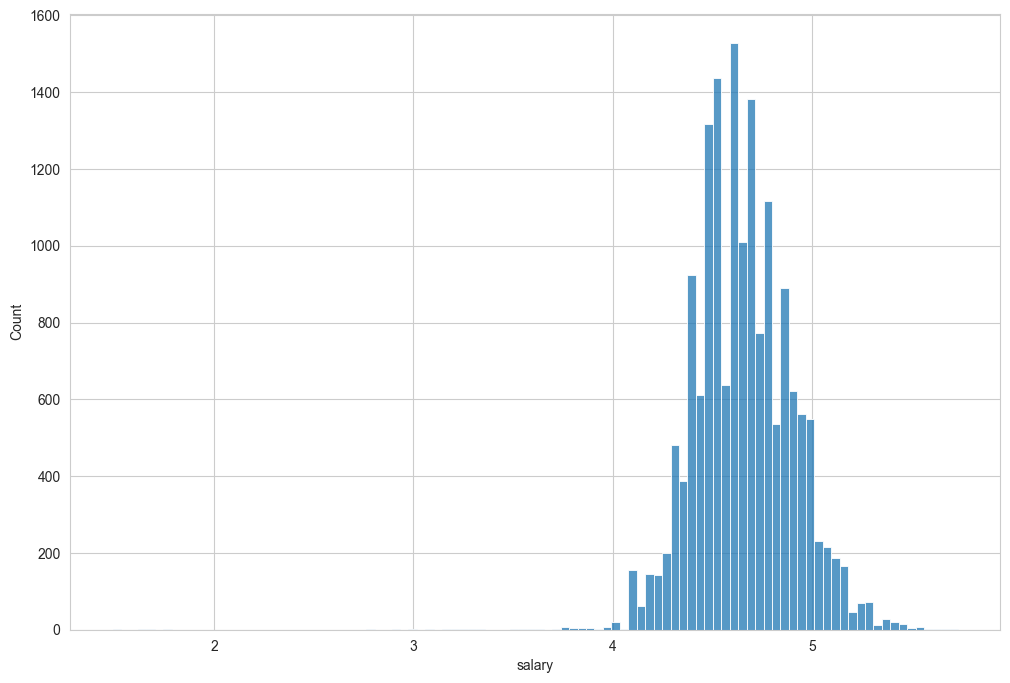

In [75]:
sns.histplot(np.log10(df.salary + 1), bins=100);

In [76]:
df.name.value_counts()

Менеджер по продажам                                          208
Продавец-консультант                                          180
Менеджер по работе с клиентами                                111
Кладовщик                                                     111
Бухгалтер                                                     108
                                                             ... 
Упаковщица/Упаковщик                                            1
Помощник официанта,ранер                                        1
Менеджер по продаже оборудования для общепита и торговли        1
Электросварщик на полуавтомат (морской регистр, НАКС НГДО)      1
Специалист-эксперт отдела правового обеспечения                 1
Name: name, Length: 9915, dtype: int64

По графику ниже, видим, что вакансий для опытных соискателей сравнительно немного. **Попробуйте визуализировать совместное распределение опыта работы и предлагаемой зп**

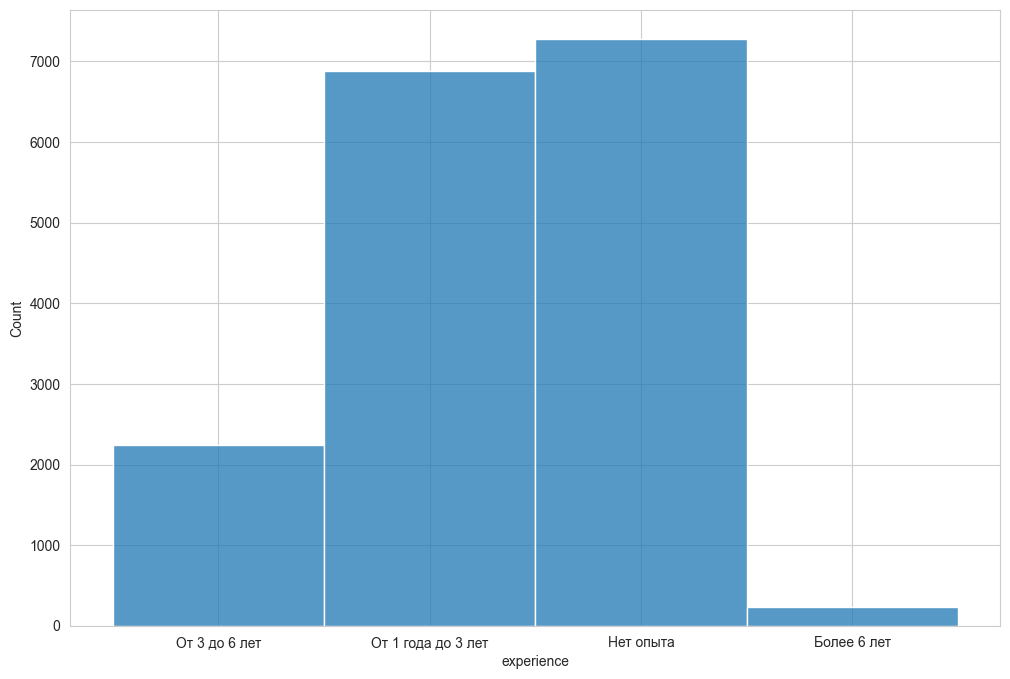

In [77]:
sns.histplot(df.experience);

Вакансий с графиком занятостью, отличной от полной совсем не много. **Наверное стоит отдельно посмотреть, не отличается ли описание таких вакансий**.

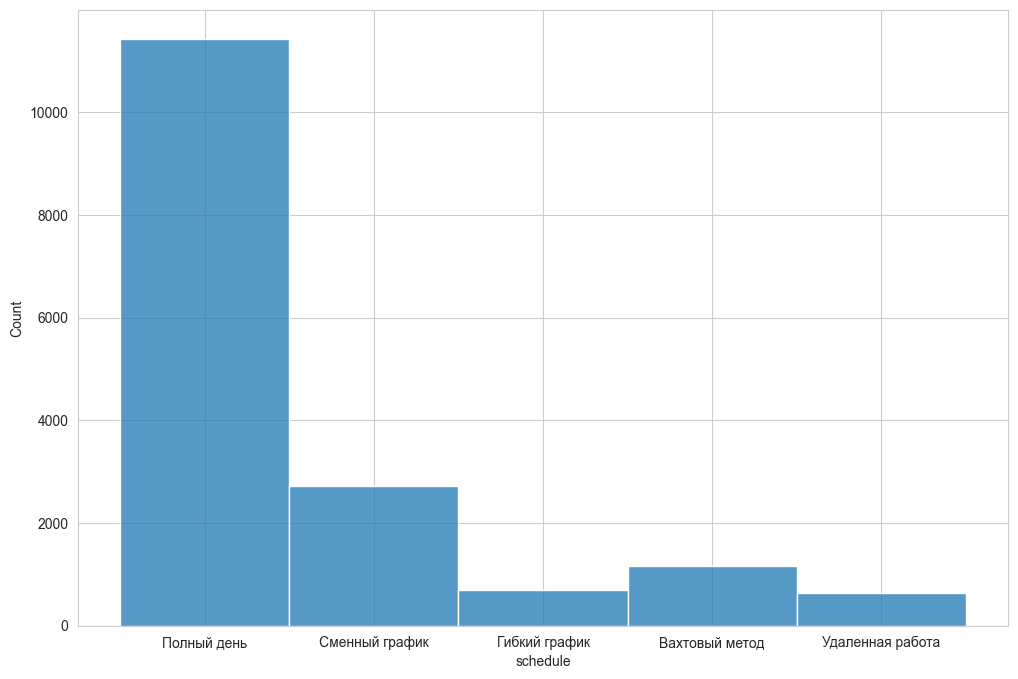

In [78]:
sns.histplot(df.schedule);

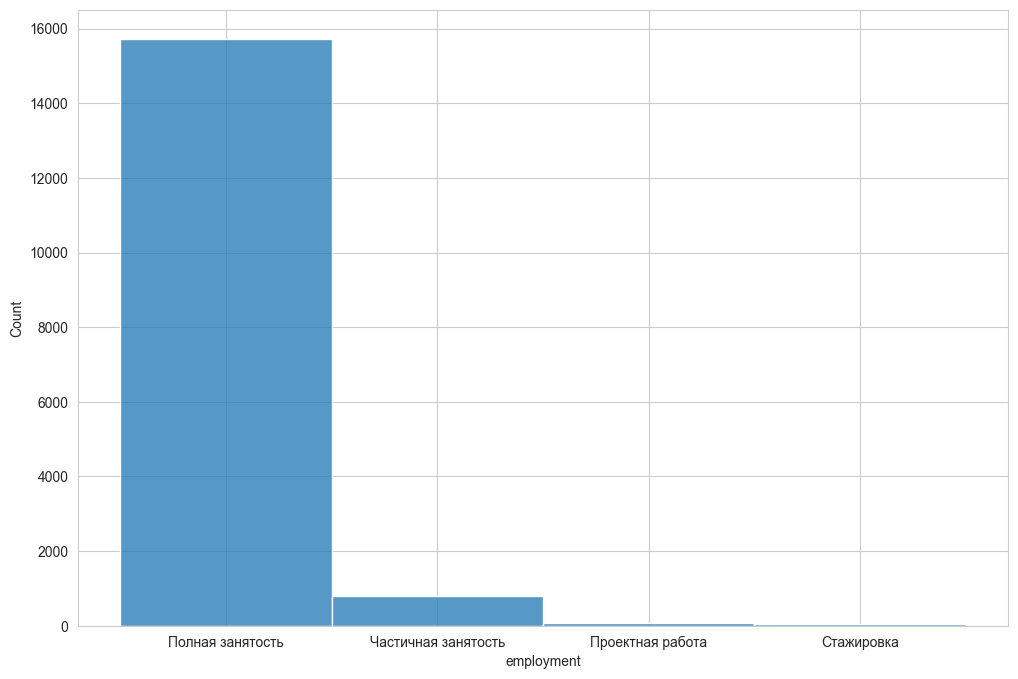

In [79]:
sns.histplot(df.employment);

Посмотрим, как часто различные требуемые навыки встречаются в поле `key_skills`. Логично предположить, что некоторые из них оказывают значимое влияние на предлагаемую зарплату. **Попробуйте проверить эту гипотезу**

In [80]:
from ast import literal_eval

In [81]:
df.columns

Index(['name', 'experience', 'schedule', 'employment', 'description',
       'key_skills', 'salary'],
      dtype='object')

In [82]:
experience_count = dict()

for skill_list in df.key_skills:
    list_of_skills = literal_eval(skill_list)
    for skill in list_of_skills:
        if skill not in experience_count:
            experience_count[skill] = 1
        else:
            experience_count[skill] += 1

experience_count = {k: v for k, v in sorted(experience_count.items(), key=lambda item: item[1], reverse=True)}
experience_count

{'Работа в команде': 2773,
 'Пользователь ПК': 2638,
 'Грамотная речь': 2226,
 'Умение работать в команде': 1152,
 'Активные продажи': 1066,
 'Деловое общение': 851,
 'Навыки продаж': 700,
 'Телефонные переговоры': 649,
 'Ведение переговоров': 630,
 'Организаторские навыки': 588,
 'Деловая переписка': 523,
 'Клиентоориентированность': 515,
 'Обучение и развитие': 494,
 'Поиск и привлечение клиентов': 479,
 'Грамотность': 462,
 'Работа с большим объемом информации': 420,
 'Прямые продажи': 402,
 'Заключение договоров': 357,
 'Холодные продажи': 352,
 'Ориентация на результат': 349,
 'AutoCAD': 344,
 'Управление персоналом': 342,
 'Консультирование': 340,
 '1С: Предприятие 8': 323,
 'Обучение персонала': 322,
 'Работа с людьми': 304,
 'Водительское удостоверение категории B': 289,
 'Навыки межличностного общения': 283,
 'Деловая коммуникация': 282,
 'Работа с кассой': 278,
 'Знание устройства автомобиля': 275,
 'Медицинская документация': 265,
 'Умение работать в коллективе': 264,
 'Англ

In [13]:
skills_count = dict()

for skill_list in df.key_skills:
    list_of_skills = literal_eval(skill_list)
    for skill in list_of_skills:
        if skill not in skills_count:
            skills_count[skill] = 1
        else:
            skills_count[skill] += 1

skills_count = {k: v for k, v in sorted(skills_count.items(), key=lambda item: item[1], reverse=True)}
skills_count

{'Работа в команде': 2773,
 'Пользователь ПК': 2638,
 'Грамотная речь': 2226,
 'Умение работать в команде': 1152,
 'Активные продажи': 1066,
 'Деловое общение': 851,
 'Навыки продаж': 700,
 'Телефонные переговоры': 649,
 'Ведение переговоров': 630,
 'Организаторские навыки': 588,
 'Деловая переписка': 523,
 'Клиентоориентированность': 515,
 'Обучение и развитие': 494,
 'Поиск и привлечение клиентов': 479,
 'Грамотность': 462,
 'Работа с большим объемом информации': 420,
 'Прямые продажи': 402,
 'Заключение договоров': 357,
 'Холодные продажи': 352,
 'Ориентация на результат': 349,
 'AutoCAD': 344,
 'Управление персоналом': 342,
 'Консультирование': 340,
 '1С: Предприятие 8': 323,
 'Обучение персонала': 322,
 'Работа с людьми': 304,
 'Водительское удостоверение категории B': 289,
 'Навыки межличностного общения': 283,
 'Деловая коммуникация': 282,
 'Работа с кассой': 278,
 'Знание устройства автомобиля': 275,
 'Медицинская документация': 265,
 'Умение работать в коллективе': 264,
 'Англ

**Визуализацию данных из тестового датасета мы предлагаем вам сделать самостоятельно**. Вполне может оказаться так, что они сильно отличаются от трейна.

In [71]:
stop_words = set(stopwords.words('russian'))
morph = MorphAnalyzer()


# функция для очистки описаний
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # избавляемся от ссылок
    text = re.sub('[^а-яёА-ЯЁ]', ' ', text)  # оставляем только кириллицу
    text = word_tokenize(text.lower())  # приводим к нижнему регистру и токенизируем по словам
    # приводим токены к нормальной форме, удаляем стоп-слова и короткие токены
    text = [morph.normal_forms(token)[0] for token in text
            if token not in stop_words and len(token) > 2]
    text = " ".join(text)  # возвращаем строку
    return text

In [63]:
# %%time
# df_train_new['cleaned'] = df_train_new.text.apply(clean_text)
# df_train_new

In [64]:
# df_test_new = pd.DataFrame()
# df_test_new['text'] = df_test.name + ' ' + df_test.description
# % time df_test_new['cleaned'] = df_test_new['text'].apply(clean_text)

# Word2Vec

Обучаемся на словах только из трейна. **Попробуйте взять окно пошире и//или изменить размер эмбеддинга.**

In [ ]:
%% time
w2v_model = Word2Vec(sentences=list(df_train_new.cleaned.str.split()),
                     size=100, window=5, workers=4, min_count=0)

CPU times: user 22 s, sys: 476 ms, total: 22.5 s
Wall time: 15.5 s


**Было бы полезно проверить, успешно ли обучился w2v на наших данных. Попробуйте провести соответствующие эксперименты**

In [ ]:
w2v_vectors = w2v_model.wv
w2v_vectors['водитель']  # проверяем, что чему-то научились

array([ 1.3463036 ,  1.6279746 , -0.80819637, -1.5439433 ,  1.4619223 ,
        0.44921255,  2.4221468 ,  0.74060154,  0.17121528,  0.8039874 ,
        0.02786321, -0.58801395,  1.415979  , -0.07509669, -0.33492896,
       -0.77970135, -0.9779893 ,  0.8131414 , -0.4147988 ,  3.094181  ,
        0.7035648 , -2.472801  ,  2.1816976 , -0.16896407,  1.6971475 ,
        2.811424  , -1.7292492 , -2.1423984 ,  2.2188766 ,  0.8584109 ,
        1.6889597 , -1.0773292 ,  0.2143993 , -0.31753206,  1.3509597 ,
        2.403309  , -0.0207357 , -0.4885437 , -0.6098075 , -2.5330298 ,
       -0.9962291 ,  3.9755101 ,  0.11124831,  1.1813569 , -0.13804296,
       -0.7435948 ,  0.74076515,  0.46329698, -0.3818832 , -1.6651418 ,
       -1.3810644 ,  0.49921042, -2.6601317 , -1.8603057 ,  0.21544793,
       -0.95246863, -0.2707167 , -1.6476122 ,  2.345113  , -1.0007364 ,
       -4.067699  , -1.156719  ,  0.5899878 ,  0.6641911 ,  0.47004163,
        0.13038036,  1.5730906 , -1.5758156 , -1.9423956 ,  1.19

In [ ]:
doc_vectors_train = []
row = 0

for doc in tqdm(df_train_new.cleaned.str.split()):
    res = np.zeros(100)
    cnt = 0
    for word in doc:
        if w2v_vectors.__contains__(word):
            res += w2v_model.wv[word]
            cnt += 1
    if cnt != 0:
        res /= cnt
    doc_vectors_train.append(res)

doc_vectors_train = np.array(doc_vectors_train)

100%|██████████| 16629/16629 [00:06<00:00, 2494.96it/s]


In [ ]:
doc_vectors_test = []
row = 0

for doc in tqdm(df_test_new.cleaned.str.split()):
    res = np.zeros(100)
    cnt = 0
    for word in doc:
        if w2v_vectors.__contains__(word):
            res += w2v_model.wv[word]
            cnt += 1
    if cnt != 0:
        res /= cnt
    doc_vectors_test.append(res)

doc_vectors_test = np.array(doc_vectors_test)

100%|██████████| 5543/5543 [00:01<00:00, 3112.36it/s]


In [69]:
# lasso = Lasso(max_iter=10_000)
# % time lasso.fit(doc_vectors_train, df_train.salary)
# y_pred = lasso.predict(doc_vectors_test)

In [70]:
# predictions = pd.DataFrame({'id': df_test.index,
#                             'salary': y_pred})
# predictions.to_csv('my_submission.csv', index=False)

## Прочие рекомендации

* не игонрируйте этап разведочного анализа данных: чем подробнее и глубже вы его сделаете, тем более последовательно вы будете двигаться к лучшему вашему решению
* вы можете попробовать какую-то другую токенизацию; возможно в бейзлайне мы не учли что-то важное
* разумно попробовать учесть те признаки, что мы проигнорировали в базовом решении (хотя бы банальный OHE-encoding)
* не обучать Word2Vec снова, а использовать предобученную и дообучать на текстах соревнования
* для перехода к числовым представлениям слов можно попробовать и другие модели: GloVe, fastText, Doc2Vec
* или даже расчехлить не слишком тяжеловесные трансформерные
* сохраняйте промежуточные результаты: некоторые алгоритмы отрабатывают довольно долго, обидно будет потерять результаты вычислений; к тому же сохранённые модели (вместе с пайплайнами предобработки, если они отличаются) будет легче состекать

# *******************************************************************************************************

In [11]:
len(df['name'])

16629

In [12]:
def get_info(df, column_name):
    # Extract the values of the specified column into a list
    column_data = list(df[column_name])
    # Concatenate all text into a single string
    corpus = ' '.join(column_data)
    # Split the string into individual words
    words = corpus.split()
    # Count the occurrences of each word
    word_counts = Counter(words)
    # Return the most common 10 words and their counts
    return word_counts.most_common(10)

In [13]:
df.columns

Index(['name', 'experience', 'schedule', 'employment', 'description',
       'key_skills', 'salary'],
      dtype='object')

In [14]:
get_info(df, 'name')

[('по', 3110),
 ('Менеджер', 1659),
 ('в', 1004),
 ('продажам', 770),
 ('Специалист', 702),
 ('и', 635),
 ('на', 600),
 ('с', 586),
 ('отдела', 545),
 ('Продавец-консультант', 533)]

In [15]:
get_info(df, 'experience')

[('лет', 9351),
 ('От', 9117),
 ('3', 9117),
 ('до', 9117),
 ('Нет', 7278),
 ('опыта', 7278),
 ('1', 6881),
 ('года', 6881),
 ('6', 2470),
 ('Более', 234)]

In [16]:
df.columns

Index(['name', 'experience', 'schedule', 'employment', 'description',
       'key_skills', 'salary'],
      dtype='object')

In [17]:
# train data
# Переведём тексты в стандартный для Python формат: кодировку Unicode U.
# Изменим кодировку методом astype():
df['name'] = df['name'].values.astype('U')
df['experience'] = df['experience'].values.astype('U')
df['schedule'] = df['schedule'].values.astype('U')
df['employment'] = df['employment'].values.astype('U')
df['description'] = df['description'].values.astype('U')
df['key_skills'] = df['key_skills'].values.astype('U')

In [84]:
# test data
# Переведём тексты в стандартный для Python формат: кодировку Unicode U.
# Изменим кодировку методом astype():
df_test['name'] = df_test['name'].values.astype('U')
df_test['experience'] = df_test['experience'].values.astype('U')
df_test['schedule'] = df_test['schedule'].values.astype('U')
df_test['employment'] = df_test['employment'].values.astype('U')
df_test['description'] = df_test['description'].values.astype('U')
df_test['key_skills'] = df_test['key_skills'].values.astype('U')

### Лемматизация

In [85]:
# def lemmatize(text):
#     m = Mystem()
#     lem = ''.join(m.lemmatize(text)).strip()
#     lem_cleared = re.sub(r'[^\w\dа-яА-ЯёЁ]+', ' ', lem)
#     return lem_cleared.lower()
#
#
# # протестируем функцию лемматизации текста
# print("Исходный текст:", df['name'][0])
# print("Лемматизированный текст:", lemmatize(df['name'][0]))

In [86]:
stop_words = set(stopwords.words('russian'))
morph = MorphAnalyzer()

# функция для очистки описаний
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # избавляемся от ссылок
    text = re.sub('[^а-яёА-ЯЁ]', ' ', text)  # оставляем только кириллицу
    text = word_tokenize(text.lower())  # приводим к нижнему регистру и токенизируем по словам
    # приводим токены к нормальной форме, удаляем стоп-слова и короткие токены
    text = [morph.normal_forms(token)[0] for token in text
            if token not in stop_words and len(token) > 2]
    text = " ".join(text)  # возвращаем строку
    return text

In [87]:
df.columns

Index(['name', 'experience', 'schedule', 'employment', 'description',
       'key_skills', 'salary'],
      dtype='object')

In [88]:
df_test.columns

Index(['name', 'experience', 'schedule', 'employment', 'description',
       'key_skills'],
      dtype='object')

In [89]:
%%time
# lemmatizing
df['name_lem'] = df.name.apply(clean_text)
df_test['name_lem'] = df_test.name.apply(clean_text)

CPU times: total: 6.3 s
Wall time: 9.14 s


In [90]:
df.head()

,name,experience,schedule,employment,description,key_skills,salary,name_lem
0,Водитель-экспедитор,От 3 до 6 лет,Полный день,Полная занятость,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...",[],42500.0,водитель экспедитор
1,Кладовщик-комплектовщик/оператор 1С,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Списывание материалов в произво...,"['знание пк', 'работа в 1С', 'Работа в команде...",50000.0,кладовщик комплектовщик оператор
2,"Продавец магазина ""Магнит"" (Кировский р-он, В....",Нет опыта,Сменный график,Полная занятость,"В крупнейшую Федеральную сеть магазинов ""Магни...",[],31500.0,продавец магазин магнит кировский уса
3,Администратор магазина (ТЦ Spar),От 1 года до 3 лет,Полный день,Полная занятость,Крупная федеральная сеть магазинов мужской и ж...,[],36700.0,администратор магазин
4,Мойщик посуды (кулинария),Нет опыта,Сменный график,Полная занятость,Обязанности: Уборка производственных площадей...,"['Пользователь ПК', 'Грамотная речь', 'Работа ...",37000.0,мойщик посуда кулинария


In [91]:
%%time
# lemmatizing
df['experience_lem'] = df['experience'].apply(clean_text)
df_test['experience_lem'] = df_test['experience'].apply(clean_text)

CPU times: total: 3.77 s
Wall time: 4.89 s


In [92]:
%%time
# lemmatizing
df['schedule_lem'] = df['schedule'].apply(clean_text)
df_test['schedule_lem'] = df_test['schedule'].apply(clean_text)

CPU times: total: 5.48 s
Wall time: 5.76 s


In [93]:
%%time
# lemmatizing
df['employment_lem'] = df['employment'].apply(clean_text)
df_test['employment_lem'] = df_test['employment'].apply(clean_text)

CPU times: total: 4.03 s
Wall time: 4.26 s


In [94]:
%%time
# lemmatizing the longest!
df['description_lem'] = df['description'].apply(clean_text)
df_test['description_lem'] = df_test['description'].apply(clean_text)

CPU times: total: 3min 44s
Wall time: 3min 56s


In [95]:
%%time
# lemmatizing
df['key_skills_lem'] = df['key_skills'].apply(clean_text)
df_test['key_skills_lem'] = df_test['key_skills'].apply(clean_text)

CPU times: total: 14.3 s
Wall time: 14.7 s


In [96]:
df.head()

,name,experience,schedule,employment,description,key_skills,salary,name_lem,experience_lem,schedule_lem,employment_lem,description_lem,key_skills_lem
0,Водитель-экспедитор,От 3 до 6 лет,Полный день,Полная занятость,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...",[],42500.0,водитель экспедитор,год,полный день,полный занятость,водитель экспедитор категория газель тент газе...,
1,Кладовщик-комплектовщик/оператор 1С,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Списывание материалов в произво...,"['знание пк', 'работа в 1С', 'Работа в команде...",50000.0,кладовщик комплектовщик оператор,год год,полный день,полный занятость,обязанность списывание материал производство п...,знание работа работа команда складской учёт ск...
2,"Продавец магазина ""Магнит"" (Кировский р-он, В....",Нет опыта,Сменный график,Полная занятость,"В крупнейшую Федеральную сеть магазинов ""Магни...",[],31500.0,продавец магазин магнит кировский уса,опыт,сменный график,полный занятость,крупный федеральный сеть магазин магнит требов...,
3,Администратор магазина (ТЦ Spar),От 1 года до 3 лет,Полный день,Полная занятость,Крупная федеральная сеть магазинов мужской и ж...,[],36700.0,администратор магазин,год год,полный день,полный занятость,крупный федеральный сеть магазин мужской женск...,
4,Мойщик посуды (кулинария),Нет опыта,Сменный график,Полная занятость,Обязанности: Уборка производственных площадей...,"['Пользователь ПК', 'Грамотная речь', 'Работа ...",37000.0,мойщик посуда кулинария,опыт,сменный график,полный занятость,обязанность уборка производственный площадь ку...,пользователь грамотный речь работа оргтехника ...


In [97]:
df.columns

Index(['name', 'experience', 'schedule', 'employment', 'description',
       'key_skills', 'salary', 'name_lem', 'experience_lem', 'schedule_lem',
       'employment_lem', 'description_lem', 'key_skills_lem'],
      dtype='object')

In [98]:
df_test.head(50)

,name,experience,schedule,employment,description,key_skills,name_lem,experience_lem,schedule_lem,employment_lem,description_lem,key_skills_lem
id,,,,,,,,,,,,
0,Главный бухгалтер,Более 6 лет,Полный день,Полная занятость,Обязанности:Осуществление организации бухгалте...,"['1С: Предприятие 8', '1C: Предприятие', 'Рабо...",главный бухгалтер,год,полный день,полный занятость,обязанность осуществление организация бухгалте...,предприятие предприятие работа документ длител...
1,Ассистент врача-стоматолога,От 1 года до 3 лет,Сменный график,Полная занятость,"Обязанности: Ассистировать врачу стоматологу,...","['Пользователь ПК', 'Работа в команде', 'Умени...",ассистент врач стоматолог,год год,сменный график,полный занятость,обязанность ассистировать врач стоматолог подг...,пользователь работа команда умение работать ко...
2,Менеджер по продажам,От 1 года до 3 лет,Полный день,Полная занятость,Если ты: хочешь построить карьеру в банковс...,[],менеджер продажа,год год,полный день,полный занятость,хотеть построить карьера банковский сектор ори...,
3,Менеджер,От 1 года до 3 лет,Полный день,Полная занятость,Динамично развивающаяся на протяжении 17 лет...,"['Оценка потребностей клиентов', 'оформление д...",менеджер,год год,полный день,полный занятость,динамично развивающийся протяжение год компани...,оценка потребность клиент оформление документа...
4,Администратор хостела,Нет опыта,Сменный график,Полная занятость,ВОЗМОЖНА РАБОТА С ПРОЖИВАНИЕМ Обязанности: Пр...,[],администратор хостел,опыт,сменный график,полный занятость,возможный работа проживание обязанность приём ...,
5,Полицейский (г. Москва),Нет опыта,Полный день,Полная занятость,Обязанности:- обеспечение правопорядка при мас...,[],полицейский москва,опыт,полный день,полный занятость,обязанность обеспечение правопорядок массовый ...,
6,Менеджер по работе с клиентами,От 1 года до 3 лет,Гибкий график,Полная занятость,Обязанности: Консультирование клиентов в студ...,"['Заключение договоров', 'Навыки продаж', 'Кон...",менеджер работа клиент,год год,гибкий график,полный занятость,обязанность консультирование клиент студия сос...,заключение договор навык продажа консультирова...
7,Администратор,Нет опыта,Полный день,Полная занятость,Приглашаем администратора в стоматологическую ...,"['Пользователь ПК', 'Работа с кассой', 'Грамот...",администратор,опыт,полный день,полный занятость,приглашать администратор стоматологический кли...,пользователь работа касса грамотный речь работ...
8,Кредитный специалист,Нет опыта,Полный день,Полная занятость,Обязанности: - консультирование клиентов по фи...,"['Грамотная речь', '1С: Предприятие 8', 'Консу...",кредитный специалист,опыт,полный день,полный занятость,обязанность консультирование клиент финансовый...,грамотный речь предприятие консультирование бу...


Методология такая:
- 1) категориальные признаки такие, как experience, schedule, employment can be converted into numerical data using Ordinal Encoder(), for example;
- 2) text columns such as name, description and key_skills - should be concatenated into one column and processed as a text.

In [33]:
train_new = df[['experience', 'schedule_lem', 'salary']]
test_new = df_test[['experience', 'schedule_lem']]

In [34]:
train_new.head()

,experience,schedule_lem,salary
0,От 3 до 6 лет,полный день,42500.0
1,От 1 года до 3 лет,полный день,50000.0
2,Нет опыта,сменный график,31500.0
3,От 1 года до 3 лет,полный день,36700.0
4,Нет опыта,сменный график,37000.0


In [35]:
test_new.head()

,experience,schedule_lem
id,,
0,Более 6 лет,полный день
1,От 1 года до 3 лет,сменный график
2,От 1 года до 3 лет,полный день
3,От 1 года до 3 лет,полный день
4,Нет опыта,сменный график


In [36]:
# creating new columns
train_text = pd.DataFrame()
test_text = pd.DataFrame()

train_text['text'] = df.name_lem + ' ' + df.description_lem + ' ' + df.key_skills_lem
test_text['text'] = df_test.name_lem + ' ' + df_test.description_lem + ' ' + df_test.key_skills

In [37]:
df_n = pd.concat([train_new, train_text], axis=1)
df_n.head(5)

,experience,schedule_lem,salary,text
0,От 3 до 6 лет,полный день,42500.0,водитель экспедитор водитель экспедитор катего...
1,От 1 года до 3 лет,полный день,50000.0,кладовщик комплектовщик оператор обязанность с...
2,Нет опыта,сменный график,31500.0,продавец магазин магнит кировский уса крупный ...
3,От 1 года до 3 лет,полный день,36700.0,администратор магазин крупный федеральный сеть...
4,Нет опыта,сменный график,37000.0,мойщик посуда кулинария обязанность уборка про...


In [38]:
test = pd.concat([test_new, test_text], axis=1)
test.head(5)

,experience,schedule_lem,text
id,,,
0,Более 6 лет,полный день,главный бухгалтер обязанность осуществление ор...
1,От 1 года до 3 лет,сменный график,ассистент врач стоматолог обязанность ассистир...
2,От 1 года до 3 лет,полный день,менеджер продажа хотеть построить карьера банк...
3,От 1 года до 3 лет,полный день,менеджер динамично развивающийся протяжение го...
4,Нет опыта,сменный график,администратор хостел возможный работа проживан...


In [39]:
df_n['experience'].unique()

array(['От 3 до 6 лет', 'От 1 года до 3 лет', 'Нет опыта', 'Более 6 лет'],
      dtype=object)

In [40]:
test['experience'].unique()

array(['Более 6 лет', 'От 1 года до 3 лет', 'Нет опыта', 'От 3 до 6 лет'],
      dtype=object)

In [41]:
# experience_map = {'От 3 до 6 лет': 0, 'От 1 года до 3 лет': 1, 'Нет опыта': 2, 'Более 6 лет': 3}
#
# df_n['experience'] = df_n['experience'].map(experience_map)
# test['experience'] = test['experience'].map(experience_map)

In [42]:
df_n.schedule_lem.unique()

array(['полный день', 'сменный график', 'гибкий график', 'вахтовый метод',
       'удалённый работа'], dtype=object)

In [43]:
# schedule_map = {'полный день': 0,
#                 'сменный график': 1,
#                 'гибкий график': 2,
#                 'вахтовый метод': 3,
#                 'удалённый работа': 4}
#
# df_n['schedule'] = df_n['schedule_lem'].map(schedule_map)
# test['schedule'] = test['schedule_lem'].map(schedule_map)

In [44]:
df_n.head()

,experience,schedule_lem,salary,text
0,От 3 до 6 лет,полный день,42500.0,водитель экспедитор водитель экспедитор катего...
1,От 1 года до 3 лет,полный день,50000.0,кладовщик комплектовщик оператор обязанность с...
2,Нет опыта,сменный график,31500.0,продавец магазин магнит кировский уса крупный ...
3,От 1 года до 3 лет,полный день,36700.0,администратор магазин крупный федеральный сеть...
4,Нет опыта,сменный график,37000.0,мойщик посуда кулинария обязанность уборка про...


## Применим другую логику обработки признаков: объединим лемматизированные колонки в одну и обработаем ее.

In [113]:
df['text'] = df['name_lem'].apply(str) + ' ' + df['experience_lem'].apply(str) + ' ' + df['schedule_lem'].apply(str) + ' ' + df['employment_lem'].apply(str) + ' ' + df['description_lem'].apply(str) + ' ' + df['key_skills_lem'].apply(str)

In [114]:
df_train = df[['text', 'salary']]
df_train.head(4)

,text,salary
0,водитель экспедитор год полный день полный зан...,42500.0
1,кладовщик комплектовщик оператор год год полны...,50000.0
2,продавец магазин магнит кировский уса опыт сме...,31500.0
3,администратор магазин год год полный день полн...,36700.0


In [117]:
df_test

,text
id,
0,главный бухгалтер год полный день полный занят...
1,ассистент врач стоматолог год год сменный граф...
2,менеджер продажа год год полный день полный за...
3,менеджер год год полный день полный занятость ...
4,администратор хостел опыт сменный график полны...
...,...
5538,специалист дистанционный контроль качество янд...
5539,продавец консультант опыт полный день полный з...
5540,фельдшер скорый медицинский помощь год сменный...


In [115]:
df_test['text'] = df_test['name_lem'].apply(str) + ' ' + df_test['experience_lem'].apply(str) + ' ' + df_test['schedule_lem'].apply(str) + ' ' + df_test['employment_lem'].apply(str) + ' ' + df_test['description_lem'].apply(str) + ' ' + df_test['key_skills_lem'].apply(str)

KeyError: 'name_lem'

In [116]:
df_test = df_test[['text']]
df_test

,text
id,
0,главный бухгалтер год полный день полный занят...
1,ассистент врач стоматолог год год сменный граф...
2,менеджер продажа год год полный день полный за...
3,менеджер год год полный день полный занятость ...
4,администратор хостел опыт сменный график полны...
...,...
5538,специалист дистанционный контроль качество янд...
5539,продавец консультант опыт полный день полный з...
5540,фельдшер скорый медицинский помощь год сменный...


In [47]:
# missing values check
pd.DataFrame(round(df_n.isna().mean() * 100, )).style.background_gradient('coolwarm')

,0
experience,0.000000
schedule_lem,0.000000
salary,0.000000
text,0.000000


### Изучим целевой признак ```'salary'```

In [48]:
df_n['salary'].head(4)

0    42500.0
1    50000.0
2    31500.0
3    36700.0
Name: salary, dtype: float64

In [49]:
df_n['salary'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 16629 entries, 0 to 16628
Series name: salary
Non-Null Count  Dtype  
--------------  -----  
16629 non-null  float64
dtypes: float64(1)
memory usage: 130.0 KB


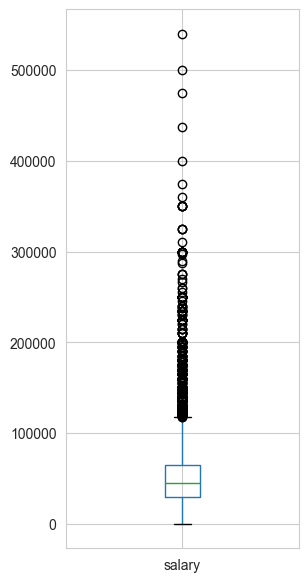

In [50]:
df_n.boxplot(column='salary', figsize=(3, 7));
plt.show();

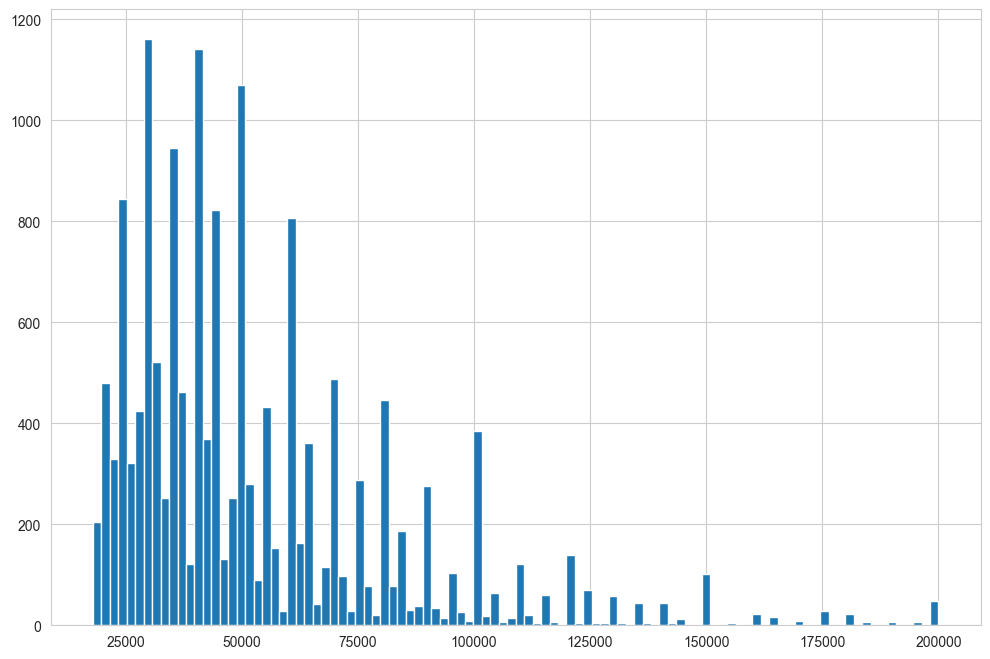

In [107]:
df_train['salary'].hist(bins=100);

In [106]:
df_train['salary'].describe().T

count     15949.000000
mean      52968.955859
std       29580.592249
min       18000.000000
25%       32000.000000
50%       45000.000000
75%       65000.000000
max      200000.000000
Name: salary, dtype: float64

In [118]:
# Remove salary outliers
df_cut = df_n[(df_n['salary'] >= 18000) & (df_n['salary'] <= 200000)]
df_train = df_train[(df_n['salary'] >= 18000) & (df_train['salary'] <= 200000)]
df_train.head()

,text,salary
0,водитель экспедитор год полный день полный зан...,42500.0
1,кладовщик комплектовщик оператор год год полны...,50000.0
2,продавец магазин магнит кировский уса опыт сме...,31500.0
3,администратор магазин год год полный день полн...,36700.0
4,мойщик посуда кулинария опыт сменный график по...,37000.0


In [119]:
df_train['salary'].describe().T

count     15949.000000
mean      52968.955859
std       29580.592249
min       18000.000000
25%       32000.000000
50%       45000.000000
75%       65000.000000
max      200000.000000
Name: salary, dtype: float64

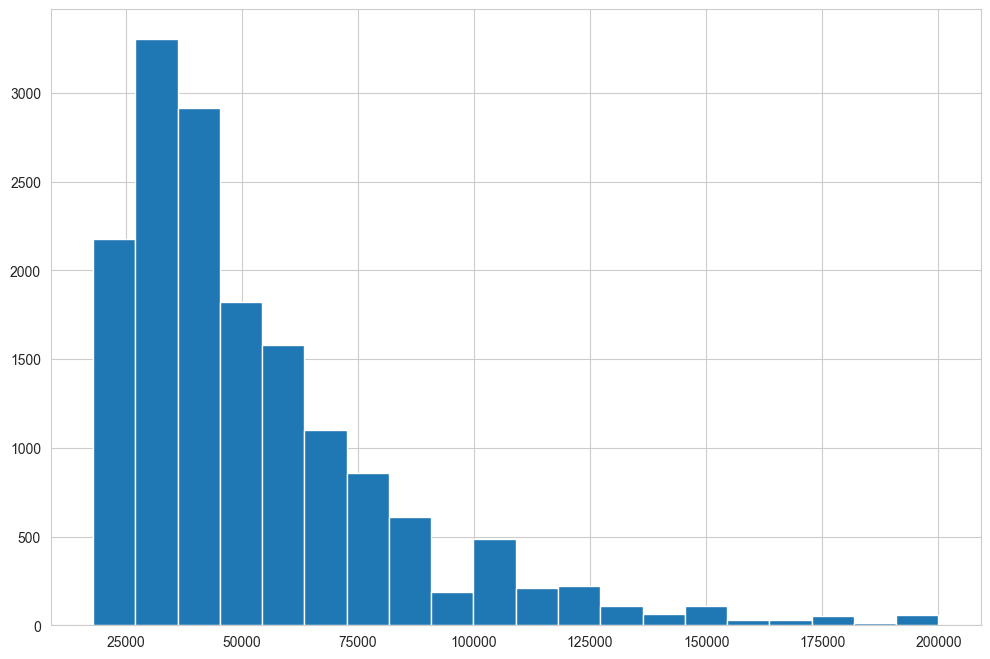

In [120]:
df_cut['salary'].hist(bins=20);

Среднее и медиана теперь более близки, выборка более нормально распределена. Целевой признак готов к обучению.

### Dividing the data into train, test; extracting subsamples for supervised learning

In [121]:
# Preprocess the categorical features
"""
In this updated code, we create a copy of the df_cut DataFrame, assign the encoded values to that
copy using .loc[row_indexer,col_indexer], and then overwrite df_cut with a copy of the modified copy.
This should resolve the SettingWithCopyWarning that you encountered.
"""
# label_encoders = {}
# for feature in cat_features:
#     label_encoders[feature] = LabelEncoder()
#     df_cut_copy = df_cut.copy()
#     df_cut_copy.loc[:, feature] = label_encoders[feature].fit_transform(df_cut_copy[feature])
#     df_cut = df_cut_copy.copy()

# Preprocess the categorical features
cat_features = ['experience', 'schedule_lem']
for feature in cat_features:
    df_cut[feature] = df_cut[feature].astype('category')

## Простые модели

In [123]:
# Vectorize the text data using BoW
vec = CountVectorizer(ngram_range=(1, 1), token_pattern=r'\b\w+\b')

In [125]:
bow = vec.fit_transform(df_train['text'])
bow

<15949x29138 sparse matrix of type '<class 'numpy.int64'>'
	with 1398189 stored elements in Compressed Sparse Row format>

In [144]:
list(vec.vocabulary_.items())[:10]

[('водитель', 3410),
 ('экспедитор', 28451),
 ('категория', 8921),
 ('газель', 4265),
 ('тент', 24729),
 ('цельнометаллический', 27487),
 ('газ', 4260),
 ('фургон', 27088),
 ('обязанность', 14881),
 ('развоз', 20116)]

In [145]:
sorted(list(vec.vocabulary_.items()), key=lambda x: x[0])[:10]

[('ааа', 0),
 ('аазс', 1),
 ('аакцент', 2),
 ('абаз', 3),
 ('абак', 4),
 ('абакан', 5),
 ('абаканвагонмаш', 6),
 ('абакина', 7),
 ('абас', 8),
 ('абатский', 9)]

In [146]:
list(vec.vocabulary_.keys())[:10]

['водитель',
 'экспедитор',
 'категория',
 'газель',
 'тент',
 'цельнометаллический',
 'газ',
 'фургон',
 'обязанность',
 'развоз']

In [147]:
len(vec.vocabulary_.items())

29138

### Попробуем обучить простейшую линейную регрессию.

In [63]:
%%time
# Create a pipeline with CountVectorizer and LinearRegression
pipe = Pipeline([
    ('vect', CountVectorizer(token_pattern=r'\b\w+\b', lowercase=False)),
    ('reg', LinearRegression())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'reg__fit_intercept': [True, False],
    'reg__positive': [True, False]
}

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_cut['text'], df_cut['salary'], test_size=0.2, random_state=5)

# Perform grid search with cross-validation
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# Print the best parameters and the corresponding MSE score
print("Best Parameters: ", grid.best_params_)
print("Best Score: ", -grid.best_score_)

Best Parameters:  {'reg__fit_intercept': True, 'reg__positive': False, 'vect__ngram_range': (2, 2)}
Best Score:  728867942.3601189
CPU times: total: 13.8 s
Wall time: 7min 39s


In [64]:
print("Правильность на обучающем наборе (линейная регрессия): {:.2f}".format(grid.score(X_train, y_train)))
print("Правильность на тестовом наборе (линейная регрессия): {:.2f}".format(grid.score(X_test, y_test)))

Правильность на обучающем наборе: -1708450.69
Правильность на тестовом наборе: -649345421.13


In [65]:
# Predict the salaries on the testing data using the best estimator
y_pred = grid.best_estimator_.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
print("MSE Linear Regression: ", mse)

MSE Linear Regression:  649345421.1275593


### Теперь обучим деревянный ансамбль Random Forest.

In [69]:
%%time
# Create a pipeline with CountVectorizer and RandomForestRegressor
pipe = Pipeline([
    ('vect', CountVectorizer(token_pattern=r'\b\w+\b', lowercase=False)),
    ('rf', RandomForestRegressor(random_state=5))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'vect__ngram_range': [(1,1), (2,2)],
    'rf__n_estimators': [5, 13, 20],
    'rf__max_depth': [3, 5, 7]
}

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_cut['text'], df_cut['salary'], test_size=0.2, random_state=5)

# Perform grid search with cross-validation
grid_rf = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_rf.fit(X_train, y_train)

# Print the best parameters and the corresponding MSE score
print("Best Parameters: ", grid.best_params_)
print("Best Score: ", -grid.best_score_)

Best Parameters:  {'reg__fit_intercept': True, 'reg__positive': False, 'vect__ngram_range': (2, 2)}
Best Score:  728867942.3601189
CPU times: total: 12.4 s
Wall time: 1min 54s


In [70]:
print("Правильность на обучающем наборе (random forest): {:.2f}".format(grid_rf.score(X_train, y_train)))
print("Правильность на тестовом наборе (random forest): {:.2f}".format(grid_rf.score(X_test, y_test)))

Правильность на обучающем наборе (random forest): -557649351.99
Правильность на тестовом наборе (random forest): -634192356.31


In [71]:
# Predict the salaries on the testing data using the best estimator
y_pred = grid_rf.best_estimator_.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
print("MSE Random Forest: ", mse)

MSE Random Forest:  634192356.3117162


### CatBoost Regressor

In [105]:
%%time
# Replace any non-string or empty string values in the 'text' column with 'NA'
df_cut['text'] = df_cut['text'].apply(lambda x: 'NA' if not isinstance(x, str) or len(x) == 0 else x)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_cut['text'],
                                                    df_cut['salary'],
                                                    test_size=0.2,
                                                    random_state=5)

# Define the pipeline for bag-of-words vectorization and CatBoostRegressor
pipe = Pipeline([
    ('vec', CountVectorizer(token_pattern=r'\b\w+\b', lowercase=False)),
    ('catboost', CatBoostRegressor(loss_function='RMSE', verbose=False))
])

# Define the hyperparameter grid to search over
param_grid = {
    'vec__ngram_range': [(1, 2)],
    'catboost__learning_rate': [0.1, 1],
    'catboost__depth': [2, 4]
    # 'catboost__l2_leaf_reg': [2, 5]
}

# Perform grid search over the hyperparameters
grid_catboost = GridSearchCV(pipe, param_grid=param_grid, cv=3, error_score='raise')
grid_catboost.fit(X_train, y_train)
# grid_results = grid_catboost.cv_results_
# for params, mean_score in zip(grid_results['params'], grid_results['mean_test_score']):
#     print(params, " - Mean test score: ", mean_score)

CPU times: total: 1h 33min 18s
Wall time: 1h 21min 27s


GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('vec',
                                        CountVectorizer(lowercase=False,
                                                        token_pattern='\\b\\w+\\b')),
                                       ('catboost',
                                        <catboost.core.CatBoostRegressor object at 0x0000021326F82790>)]),
             param_grid={'catboost__depth': [2, 4],
                         'catboost__learning_rate': [0.1, 1],
                         'vec__ngram_range': [(1, 2)]})

In [106]:
# Print the best hyperparameters and the corresponding MSE score
print("Best Hyperparameters CatBoost Regressor: ", grid_catboost.best_params_)
y_pred = grid_catboost.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE CatBoost Regressor: ", mse)

Best Hyperparameters CatBoost Regressor:  {'catboost__depth': 4, 'catboost__learning_rate': 0.1, 'vec__ngram_range': (1, 2)}
MSE CatBoost Regressor:  477290210.42160654


### Gradient Boosting

In [110]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MaxAbsScaler

In [113]:
%%time
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_cut['text'], df_cut['salary'], test_size=0.2, random_state=5)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_cut['text'],
                                                    df_cut['salary'],
                                                    test_size=0.2,
                                                    random_state=5)

# Create a pipeline to preprocess text and apply GradientBoostingRegressor
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(token_pattern=r'\b\w+\b', lowercase=False)),
    ('scaler', MaxAbsScaler()),
    ('model', GradientBoostingRegressor())
])

# Define the hyperparameter grid to search over
param_grid = {
    'vectorizer__ngram_range': [(1, 2)],
    'model__learning_rate': [0.001, 0.1],
    'model__max_depth': [4, 6, 8],
    # 'model__min_samples_leaf': [1, 3, 5]
}

# Perform grid search over the hyperparameters
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=3, error_score='raise')
grid_search.fit(X_train, y_train)

CPU times: total: 51min 57s
Wall time: 1h 17min 18s


GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(lowercase=False,
                                                        token_pattern='\\b\\w+\\b')),
                                       ('scaler', MaxAbsScaler()),
                                       ('model', GradientBoostingRegressor())]),
             param_grid={'model__learning_rate': [0.001, 0.1],
                         'model__max_depth': [4, 6, 8],
                         'vectorizer__ngram_range': [(1, 2)]})

In [114]:
# Evaluate the best model on the testing data
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)

Mean Squared Error:  495273411.2721613


## CarBoost Regressor показывает наилучший результат, попробуем добавить признаков в модель.

In [272]:
!pip install fasttext==0.6.0 -qq

  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [11 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-39
  creating build\lib.win-amd64-cpython-39\fasttext
  copying fasttext\model.py -> build\lib.win-amd64-cpython-39\fasttext
  copying fasttext\__init__.py -> build\lib.win-amd64-cpython-39\fasttext
  running build_ext
  building 'fasttext.fasttext' extension
  error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fasttext
  error: subprocess-exited-with-error
  
  Running setup.py install for fasttext did not run successfully.
  exit code: 1
  
  [13 lines of output]
  running install
  c:\users\h

In [274]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import word2vec
from catboost import CatBoostRegressor

In [161]:
class Word2VecTransformer:
    def __init__(self, model):
        self.model = model
        self.dim = model.vector_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.model[w] for w in words if w in self.model] or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [188]:
# Replace any non-string or empty string values in the 'text' column with 'NA'
df_cut['text'] = df_cut['text'].apply(lambda x: 'NA' if not isinstance(x, str) or len(x) == 0 else x)

# Tokenize the text
tokenized_text = [text.split() for text in df_cut['text']]

# Train the Word2Vec model
w2v = word2vec.Word2Vec(tokenized_text, workers=4, vector_size=200, min_count=10, window=10, sample=1e-3)
w2v.wv.most_similar(positive=['плюс'], topn=10)

[('гарант', 0.6878997087478638),
 ('базовый', 0.5640345215797424),
 ('ооп', 0.5528475046157837),
 ('фреймворк', 0.5451531410217285),
 ('хотя', 0.5389792323112488),
 ('приветствоваться', 0.5158228278160095),
 ('потребоваться', 0.513831615447998),
 ('версия', 0.5008562803268433),
 ('субд', 0.4961123466491699),
 ('преимущество', 0.4929790794849396)]

In [313]:
"""
1) The error occurs because the df_cut['w2v_embedding'].values is a 1D array while the other features
(experience and schedule_lem) are 2D arrays. The reshape function is used to
convert the 1D array to a 2D array with a single column.

2) It seems that the error is caused by trying to convert a 2D array to float data type
using astype(float). To fix the error, you can convert each column of the 2D array
to float data type individually using the astype method of a pandas DataFrame.
"""# Replace any non-string or empty string values in the 'text' column with 'NA'
df_cut['text'] = df_cut['text'].apply(lambda x: 'NA' if not isinstance(x, str) or len(x) == 0 else x)

# Tokenize the text
tokenized_text = [text.split() for text in df_cut['text']]

# Train the Word2Vec model
w2v = word2vec.Word2Vec(tokenized_text, workers=4, vector_size=200, min_count=10, window=10, sample=1e-3)
w2v.wv.most_similar(positive=['плюс'], topn=10)

def get_tweet_embedding(lemmas, model=w2v.wv, embedding_size=200):

    res = np.zeros(embedding_size)
    cnt = 0
    for word in lemmas.split():
        if word in model:
            res += np.array(model[word])
            cnt += 1
    if cnt:
        res = res / cnt
    return res

df_cut['w2v_embedding'] = df_cut['text'].map(get_tweet_embedding)
test['w2v_embedding'] = test['text'].map(get_tweet_embedding)

# One-hot encode the categorical features
experience = pd.get_dummies(df_cut['experience'], prefix='experience')
schedule_lem = pd.get_dummies(df_cut['schedule_lem'], prefix='schedule_lem')

# Concatenate the numerical and categorical features

# Get the maximum length of the arrays in the 'w2v_embedding' column
max_len = df_cut['w2v_embedding'].apply(lambda x: len(x)).max()

# Pad the arrays with zeros to ensure that all arrays have the same length
X_w2v = np.array([np.pad(x, (0, max_len - len(x)), mode='constant') for x in df_cut['w2v_embedding']])

# Concatenate the numerical and categorical features
X = np.concatenate([X_w2v, experience.values, schedule_lem.values], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df_cut['salary'].values, test_size=0.2, random_state=5)

# вычисляем минимум и максимум
scaler = MinMaxScaler().fit(X_train)

# масштабируем обучающие данные
X_train_scaled = scaler.fit_transform(X_train)

# масштабируем тестовые данные и оцениваем качество на масштабированных данных
X_test_scaled = scaler.transform(X_test)

In [229]:
%%time
# Define the hyperparameter grid to search over
param_grid = {
    'depth': [7, 8],
    'learning_rate': [0.1, 1],
    # 'l2_leaf_reg': [1, 3, 5]
}

# Perform grid search over the hyperparameters
catboost = CatBoostRegressor(loss_function='RMSE', verbose=100)
grid_search = GridSearchCV(catboost, param_grid=param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

0:	learn: 28965.0332523	total: 47.3ms	remaining: 47.2s
100:	learn: 19688.0779712	total: 3.29s	remaining: 29.3s
200:	learn: 16712.6478086	total: 6.56s	remaining: 26.1s
300:	learn: 14388.8301888	total: 9.66s	remaining: 22.4s
400:	learn: 12500.4325045	total: 12.8s	remaining: 19.1s
500:	learn: 11065.9126698	total: 15.8s	remaining: 15.8s
600:	learn: 9782.8261482	total: 18.9s	remaining: 12.6s
700:	learn: 8677.4927731	total: 22.1s	remaining: 9.42s
800:	learn: 7740.0642647	total: 25.4s	remaining: 6.3s
900:	learn: 6878.4108780	total: 28.5s	remaining: 3.13s
999:	learn: 6199.0632102	total: 31.5s	remaining: 0us
0:	learn: 29033.1626272	total: 35.5ms	remaining: 35.5s
100:	learn: 19853.1003061	total: 3.15s	remaining: 28s
200:	learn: 16638.9759433	total: 6.22s	remaining: 24.7s
300:	learn: 14321.0811290	total: 9.28s	remaining: 21.6s
400:	learn: 12556.9610439	total: 12.4s	remaining: 18.5s
500:	learn: 11030.0437308	total: 15.4s	remaining: 15.4s
600:	learn: 9736.7956316	total: 18.5s	remaining: 12.3s
700:	

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001840780A730>,
             param_grid={'depth': [7, 8], 'learning_rate': [0.1, 1]})

In [230]:
 # наилучшие гиперпараметры, подобранные поиском по сетке
grid_search.best_params_

{'depth': 7, 'learning_rate': 0.1}

In [231]:
%%time
final_cat = CatBoostRegressor(depth=grid_search.best_params_['depth'],
        # l2_leaf_reg=grid_search.best_params_['l2_leaf_reg'],
        learning_rate=grid_search.best_params_['learning_rate'],
        loss_function='RMSE',
        verbose=100)

final_cat.fit(X_train_scaled, y_train)

0:	learn: 28927.1084244	total: 99.9ms	remaining: 1m 39s
100:	learn: 20218.7248532	total: 3.87s	remaining: 34.4s
200:	learn: 17321.0151212	total: 6.75s	remaining: 26.8s
300:	learn: 15316.6620128	total: 9.62s	remaining: 22.3s
400:	learn: 13626.1694214	total: 12.5s	remaining: 18.7s
500:	learn: 12238.4633086	total: 15.4s	remaining: 15.3s
600:	learn: 11051.1750917	total: 18.3s	remaining: 12.1s
700:	learn: 9999.7818486	total: 21.2s	remaining: 9.05s
800:	learn: 9066.9363325	total: 24.2s	remaining: 6s
900:	learn: 8245.3339674	total: 27s	remaining: 2.97s
999:	learn: 7478.7817918	total: 29.9s	remaining: 0us
CPU times: total: 1min 6s
Wall time: 30.5 s


In [232]:
best_params = final_cat.get_params()
print("Best Hyperparameters CatBoost Regressor: ", best_params)
y_pred = final_cat.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE CatBoost Regressor: ", mse)

Best Hyperparameters CatBoost Regressor:  {'learning_rate': 0.1, 'depth': 7, 'loss_function': 'RMSE', 'verbose': 100}
MSE CatBoost Regressor:  1055476827.9843959


In [235]:
y_pred = grid_search.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
print("R2 Score: ", r2)

R2 Score:  0.4518342978773303


### Basic Neural Network

Let's try some basic NN.

In [314]:
df_cut['text'] = df_cut['text'].apply(lambda x: 'NA' if not isinstance(x, str) or len(x) == 0 else x)

# Tokenize the text
tokenized_text = [text.split() for text in df_cut['text']]

# Train the Word2Vec model
w2v = word2vec.Word2Vec(tokenized_text, workers=4, vector_size=200, min_count=10, window=10, sample=1e-3)
w2v.wv.most_similar(positive=['плюс'], topn=10)

def get_tweet_embedding(lemmas, model=w2v.wv, embedding_size=200):

    res = np.zeros(embedding_size)
    cnt = 0
    for word in lemmas.split():
        if word in model:
            res += np.array(model[word])
            cnt += 1
    if cnt:
        res = res / cnt
    return res

df_cut['w2v_embedding'] = df_cut['text'].map(get_tweet_embedding)
test['w2v_embedding'] = test['text'].map(get_tweet_embedding)

# One-hot encode the categorical features
experience = pd.get_dummies(df_cut['experience'], prefix='experience')
schedule_lem = pd.get_dummies(df_cut['schedule_lem'], prefix='schedule_lem')

# Concatenate the numerical and categorical features

# Get the maximum length of the arrays in the 'w2v_embedding' column
max_len = df_cut['w2v_embedding'].apply(lambda x: len(x)).max()

# Pad the arrays with zeros to ensure that all arrays have the same length
X_w2v = np.array([np.pad(x, (0, max_len - len(x)), mode='constant') for x in df_cut['w2v_embedding']])

# Concatenate the numerical and categorical features
X = np.concatenate([X_w2v, experience.values, schedule_lem.values], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df_cut['salary'].values, test_size=0.2, random_state=5)

# вычисляем минимум и максимум
scaler = MinMaxScaler().fit(X_train)

# масштабируем обучающие данные
X_train_scaled = scaler.fit_transform(X_train)

# масштабируем тестовые данные и оцениваем качество на масштабированных данных
X_test_scaled = scaler.transform(X_test)

# Initialize the model
model = Sequential()

# Add the first hidden layer
model.add(Dense(units=64, activation='relu', input_dim=X_train_scaled.shape[1]))

# Add the second hidden layer
model.add(Dense(units=32, activation='relu'))

# Add the output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32)

Epoch 1/100
399/399 [==============================] - 1s 870us/step - loss: 3300231168.0000
Epoch 2/100
399/399 [==============================] - 0s 866us/step - loss: 1192893824.0000
Epoch 3/100
399/399 [==============================] - 0s 872us/step - loss: 870295296.0000
Epoch 4/100
399/399 [==============================] - 0s 874us/step - loss: 863912256.0000
Epoch 5/100
399/399 [==============================] - 0s 852us/step - loss: 856647936.0000
Epoch 6/100
399/399 [==============================] - 0s 883us/step - loss: 849236864.0000
Epoch 7/100
399/399 [==============================] - 0s 867us/step - loss: 841965376.0000
Epoch 8/100
399/399 [==============================] - 0s 882us/step - loss: 833777216.0000
Epoch 9/100
399/399 [==============================] - 0s 1ms/step - loss: 825595584.0000
Epoch 10/100
399/399 [==============================] - 0s 1ms/step - loss: 816706688.0000
Epoch 11/100
399/399 [==============================] - 0s 895us/step - loss: 807

In [315]:
# Make predictions using your model
y_pred = model.predict(X_test)

# Calculate the MSE between the actual target values and the predicted values
mse = mean_squared_error(y_test, y_pred)

# Print the MSE
print("MSE:", mse)

100/100 [==============================] - 0s 641us/step
MSE: 2179205571.558225


Преодработаем датасет ```df_new```, векторизую мешок слов.

In [59]:
df_new['salary'] = df_new['salary'].astype(float)

# Tokenize the text
tokenized_text = [text.split() for text in df_new['text']]

# Create the bag of words representation
vectorizer = CountVectorizer()
bow_text = vectorizer.fit_transform(df_new['text'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(bow_text.toarray(), df_new['salary'], test_size=0.2, random_state=5)

# Initialize the model
model_2 = Sequential()

# Add the first hidden layer
model_2.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))

# Add the second hidden layer
model_2.add(Dense(units=32, activation='relu'))

# Add the output layer
model_2.add(Dense(units=1))

# Compile the model
model_2.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_2.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
399/399 [==============================] - 8s 19ms/step - loss: 3427220480.0000
Epoch 2/100
399/399 [==============================] - 7s 17ms/step - loss: 1718784768.0000
Epoch 3/100
399/399 [==============================] - 6s 16ms/step - loss: 1154588160.0000
Epoch 4/100
399/399 [==============================] - 7s 17ms/step - loss: 1027074880.0000
Epoch 5/100
399/399 [==============================] - 7s 16ms/step - loss: 924587264.0000
Epoch 6/100
399/399 [==============================] - 6s 16ms/step - loss: 836746688.0000
Epoch 7/100
399/399 [==============================] - 6s 16ms/step - loss: 762681280.0000
Epoch 8/100
399/399 [==============================] - 6s 16ms/step - loss: 701882432.0000
Epoch 9/100
399/399 [==============================] - 6s 16ms/step - loss: 651901760.0000
Epoch 10/100
399/399 [==============================] - 6s 16ms/step - loss: 611419136.0000
Epoch 11/100
399/399 [==============================] - 7s 16ms/step - loss: 57767846

In [60]:
# Make predictions using your model
y_pred_2 = model_2.predict(X_test)

# Calculate the MSE between the actual target values and the predicted values
mse_2 = mean_squared_error(y_test, y_pred_2)

# Print the MSE
print("MSE model_2:", mse_2)

100/100 [==============================] - 0s 4ms/step
MSE model_2: 688970910.1508247


### CNN

In [61]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout

# Initialize the model
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(209, 1)))
model_cnn.add(MaxPooling1D(pool_size=2))
# Add a dropout layer with a rate of 0.5 to prevent overfitting
model_cnn.add(Dropout(rate=0.5))
# Flatten the output from the convolutional layer
model_cnn.add(Flatten())
# Add the first hidden layer with 64 units and 'relu' activation
model_cnn.add(Dense(units=64, activation='relu'))
# Add a dropout layer with a rate of 0.5 to prevent overfitting
model_cnn.add(Dropout(rate=0.5))
# Add the second hidden layer with 32 units and 'relu' activation
model_cnn.add(Dense(units=32, activation='relu'))
# Add the output layer with one unit
model_cnn.add(Dense(units=1))
# Compile the model
model_cnn.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_cnn.fit(X_train_scaled, y_train, epochs=100, batch_size=32)

NameError: name 'X_train_scaled' is not defined

In [300]:
# Evaluate the model on the test data
test_loss = model_cnn.evaluate(X_test_scaled, y_test)

# Print the MSE score
print('Test MSE:', test_loss)

100/100 [==============================] - 0s 2ms/step - loss: 611609344.0000
Test MSE: 611609344.0


In [301]:
# Make predictions using your model
y_pred = model_cnn.predict(X_test)

# Calculate the MSE between the actual target values and the predicted values
mse_cnn = mean_squared_error(y_test, y_pred)

# Print the MSE
print("MSE CNN:", mse_cnn)

100/100 [==============================] - 0s 2ms/step
MSE CNN: 2203585643.316093


## Predictions on an actual test data

In [278]:
# Replace any non-string or empty string values in the 'text' column with 'NA'
test['text'] = test['text'].apply(lambda x: 'NA' if not isinstance(x, str) or len(x) == 0 else x)

# Tokenize the text
tokenized_text = [text.split() for text in test['text']]

# Train the Word2Vec model
w2v = word2vec.Word2Vec(tokenized_text, workers=4, vector_size=200, min_count=10, window=10, sample=1e-3)
w2v.wv.most_similar(positive=['плюс'], topn=10)

# One-hot encode the categorical features
experience = pd.get_dummies(test['experience'], prefix='experience')
schedule_lem = pd.get_dummies(test['schedule_lem'], prefix='schedule_lem')

# Concatenate the numerical and categorical features

# Get the maximum length of the arrays in the 'w2v_embedding' column
max_len = test['w2v_embedding'].apply(lambda x: len(x)).max()

# Pad the arrays with zeros to ensure that all arrays have the same length
X_w2v = np.array([np.pad(x, (0, max_len - len(x)), mode='constant') for x in test['w2v_embedding']])

# Concatenate the numerical and categorical features
X = np.concatenate([X_w2v, experience.values, schedule_lem.values], axis=1)

# Scale the data
scaler = MinMaxScaler().fit(X)
X_scaled_actual_test = scaler.transform(X)

### CatBoostRegressor

In [279]:
# Use the final CatBoost Regressor model to make predictions on the test data
y_pred_cat = final_cat.predict(X_scaled_actual_test)
y_pred_cat

array([68122.74198718, 73163.06011505, 84159.30725351, ...,
       84587.82295136, 54594.32793042, 55422.48690524])

In [280]:
test.head()

,experience,schedule_lem,text,w2v_embedding
id,,,,
0,Более 6 лет,полный день,главный бухгалтер обязанность осуществление ор...,"[-0.0017661690168703597, 0.3922715710179459, -..."
1,От 1 года до 3 лет,сменный график,ассистент врач стоматолог обязанность ассистир...,"[0.13890426800892092, 0.007075214404056766, -0..."
2,От 1 года до 3 лет,полный день,менеджер продажа хотеть построить карьера банк...,"[0.15837500702616744, 0.35205164239775605, 0.0..."
3,От 1 года до 3 лет,полный день,менеджер динамично развивающийся протяжение го...,"[0.22894530093484283, 0.2416285795362955, -0.0..."
4,Нет опыта,сменный график,администратор хостел возможный работа проживан...,"[0.23800812328098278, 0.05948061611126648, -0...."


In [281]:
acual_test_pred = test[['text']]
acual_test_pred['salary'] = final_cat.predict(X_scaled_actual_test)
acual_test_pred.head()

,text,salary
id,,
0,главный бухгалтер обязанность осуществление ор...,68122.741987
1,ассистент врач стоматолог обязанность ассистир...,73163.060115
2,менеджер продажа хотеть построить карьера банк...,84159.307254
3,менеджер динамично развивающийся протяжение го...,62588.957242
4,администратор хостел возможный работа проживан...,58849.999808


In [282]:
acual_test_pred_cat = acual_test_pred.drop(columns='text')
acual_test_pred_cat.head(4)

,salary
id,
0,68122.741987
1,73163.060115
2,84159.307254
3,62588.957242


In [283]:
acual_test_pred_cat['salary'] = acual_test_pred_cat['salary'].astype(int)
acual_test_pred_cat.head()

,salary
id,
0,68122
1,73163
2,84159
3,62588
4,58849


In [292]:
acual_test_pred_cat.to_csv('acual_test_pred_cat.csv')

### Basic Neural Network (without convolution)

In [286]:
acual_test_pred_nn = test[['text']]
acual_test_pred_nn['salary'] = model.predict(X_scaled_actual_test)
acual_test_pred_nn.head()

174/174 [==============================] - 0s 723us/step


,text,salary
id,,
0,главный бухгалтер обязанность осуществление ор...,74551.125000
1,ассистент врач стоматолог обязанность ассистир...,49668.117188
2,менеджер продажа хотеть построить карьера банк...,59146.085938
3,менеджер динамично развивающийся протяжение го...,55808.343750
4,администратор хостел возможный работа проживан...,55585.847656


In [287]:
acual_test_pred_nn = acual_test_pred_nn.drop(columns='text')
acual_test_pred_nn.head(4)

,salary
id,
0,74551.125000
1,49668.117188
2,59146.085938
3,55808.343750


In [288]:
acual_test_pred_nn['salary'] = acual_test_pred_nn['salary'].astype(int)
acual_test_pred_nn.head()

,salary
id,
0,74551
1,49668
2,59146
3,55808
4,55585


In [289]:
acual_test_pred_nn.to_csv('acual_test_pred_nn.csv')

In [290]:
acual_test_pred_nn.shape

(5543, 1)

### CNN

In [305]:
actual_test_pred_cnn = test[['text']]
actual_test_pred_cnn['salary'] = model_cnn.predict(X_scaled_actual_test)

actual_test_pred_cnn = actual_test_pred_cnn.drop(columns='text')

actual_test_pred_cnn['salary'] = actual_test_pred_cnn['salary'].astype(int)
actual_test_pred_cnn.head()

actual_test_pred_cnn.to_csv('actual_test_pred_cnn.csv')

174/174 [==============================] - 0s 2ms/step


In [126]:
df_test.head()

,text
id,
0,главный бухгалтер год полный день полный занят...
1,ассистент врач стоматолог год год сменный граф...
2,менеджер продажа год год полный день полный за...
3,менеджер год год полный день полный занятость ...
4,администратор хостел опыт сменный график полны...


In [127]:
# Tokenize the text
tokenized_text = [text.split() for text in df_test['text'].values]
# tokenized_tweets = [tweet.split() for tweet in train['lemmas'].values]

%time
w2v = word2vec.Word2Vec(tokenized_text, workers=4, vector_size=200, min_count=10, window=10, sample=1e-3)



# Create the bag of words representation
vectorizer = CountVectorizer()
bow_text = vectorizer.fit_transform(df_test['text'])

In [130]:
pred_cnn_2 = test[['text']]
actual_test_pred_cnn['salary'] = model_2.predict(bow_text)

actual_test_pred_cnn = actual_test_pred_cnn.drop(columns='text')

# actual_test_pred_cnn['salary'] = actual_test_pred_cnn['salary'].astype(int)
actual_test_pred_cnn.head()

actual_test_pred_cnn.to_csv('actual_test_pred_cnn.csv')

InvalidArgumentError: {{function_node __wrapped__SerializeManySparse_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[1] = [0,1428] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SerializeManySparse]